<h1><center>
    ECE 438 - Laboratory 5a<br/>
    Digital Filter Design (Week 1)<br/>
    <small>Last updated on May 9, 2022</small>
</center></h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd

In [2]:
# make sure the plot is displayed in this notebook
%matplotlib inline
# specify the size of the plot
plt.rcParams['figure.figsize'] = (16, 6)

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

<h2 style="color:salmon;"><left>1. Introduction</left></h2>

This is the first part of a two week laboratory in digital filter design. This lab covers some basic examples of FIR and IIR filters, introduces the concepts of FIR filter design, and covers systematic methods of designing both FIR and IIR filters.

<h2 style="color:salmon;"><left>2. Background on Digital Filters</left></h2>

In digital signal processing applications, it is often necessary to change the relative amplitudes of frequency components or remove undesired frequencies of a signal. This process is called **filtering**. Digital filters are used in a variety of applications. In Lab 4, we saw that digital filters may be used in systems that perform interpolation and decimation on discrete-time signals. Digital filters are also used in audio systems that allow the listener to adjust the bass (low-frequency energy) and the treble (high frequency energy) of audio signals.

Digital filter design requires the use of both frequency domain and time domain techniques.  This is because filter design specifications are often given in the frequency domain, but filters are usually implemented in the time domain with a difference equation. Typically, frequency domain analysis is done using the Z-transform and the discrete-time Fourier Transform (DTFT).

In general, a linear and time-invariant causal digital filter with input $x(n)$ and output $y(n)$ may be specified by its difference equation

\begin{equation}
    y(n)=\sum_{i=0}^{N-1}b_ix[n-i]-\sum_{k=1}^Ma_ky[n-k]\tag{1}
\end{equation}

where $b_i$ and $a_k$ are coefficients which parameterize the filter. This filter is said to have $N$ zeros and $M$ poles. Each new value of the output signal, $y[n]$, is determined by past values of the output, and by present and past values of the input. The impulse response, $h[n]$, is the response of the filter to an input of $\delta[n]$, and is therefore the solution to the recursive difference equation

\begin{equation}
    h(n)=\sum_{i=0}^{N-1}b_i\delta[n-i]-\sum_{k=1}^Ma_kh[n-k]\tag{2}
\end{equation}

There are two general classes of digital filters: infinite impulse response (IIR) and finite impulse response (FIR). The FIR case occurs when $a_k=0$, for all $k$. Such a filter is said to have no poles, only zeros. In this case, the difference equation (2) becomes

\begin{equation}
    h[n]=\sum_{i=0}^{N-1}b_i\delta[n-i]\tag{3}
\end{equation}

Since (3) is no longer recursive, the impulse response has finite duration $N$.

In the case where $a_k\neq0$, the difference equation usually represents an IIR filter. In this case, (2) will usually generate an impulse response which has non-zero values as $n\rightarrow\infty$. However, later we will see that for certain values of $a_k \neq 0$ and $b_i$ , it is possible to generate an FIR filter response.

The Z-transform is the major tool used for analyzing the frequency response of filters and their difference equations. The Z-transform of a discrete-time signal, $x[n]$, is given by

\begin{equation}
    X(z)=\sum_{n=-\infty}^{\infty}x[n]z^{-n}.
\end{equation}

where $z$ is a complex variable. The DTFT may be thought of as a special case of the Z-transform where $z$ is evaluated on the unit circle in the complex plane.

\begin{align}
    X(e^{j\omega})&=X(z)|_{z=e^{j\omega}}\\
    &=\sum_{n=-\infty}^{\infty}x[n]e^{-j\omega n}
\end{align}

From the definition of the Z-transform, a change of variable $m = n − K$ shows that a delay of $K$ samples in the time domain is equivalent to multiplication by $z^{−K}$ in the Z-transform domain.

\begin{align}
    x[n-K]&\leftrightarrow\sum_{n=-\infty}^\infty x[n-K]z^{-n}\\
    &=\sum_{m=-\infty}^{\infty}x[m]z^{-(m+K)}\\
    &=z^{-K}\sum_{m=-\infty}^{\infty}x[m]z^{-m}\\
    &=z^{-K}X(z)
\end{align}

We may use this fact to re-write Eq. (1) in the Z-transform domain, by taking Z-transforms of both sides of the equation:

\begin{align}
    Y(z)&=\sum_{i=0}^{N-1}b_iz^{-i}X(z)-\sum_{k=1}^Ma_kz^{-k}Y(z)\\
    Y(z)\left(1+\sum_{k=1}^Ma_kz^{-k}\right)&=X(z)\sum_{i=0}^{N-1}b_iz^{-i}\\
    H(z)&\triangleq\frac{Y(z)}{X(z)}=\frac{\sum_{i=0}^{N-1}b_iz^{-i}}{1+\sum_{k=1}^Ma_kz^{-k}}
\end{align}

From this formula, we see that any filter which can be represented by a linear difference equation with constant coefficients has a rational transfer function (i.e. a transfer function which is a ratio of polynomials). From this result, we may compute the frequency response of the filter by evaluating $H(z)$ on the unit circle:

\begin{equation}
    H(e^{j\omega})=\frac{\sum_{i=0}^{N-1}b_ie^{-j\omega i}}{1+\sum_{k=1}^Ma_ke^{-j\omega k}}
\end{equation}

There are many different methods for implementing a general recursive difference equation of the form (1). Depending on the application, some methods may be more robust to quantization error, require fewer multiplies or adds, or require less memory. Figure 1 shows a system diagram known as the direct form implementation; it works for any discrete-time filter described by difference equation (1). Note that the boxes containing the symbol $z^{−1}$ represent unit delays, while a parameter written next to a signal path represents multiplication by that parameter.

<figure>
    <img src="imgs/figure1.png" style="width:70%">
    <em><center>Figure 1: Direct form implementation for a discrete-time filter described by a general difference equation of the form in equation (1).</center></em>
</figure>

<h2 style="color:salmon;"><left>3. Design of a Simple FIR Filter</left></h2>

<figure>
    <img src="imgs/figure2.png" style="width:60%">
    <em><center>Figure 2: Location of two zeros for simple a FIR filter.</center></em>
</figure>
          
To illustrate the use of zeros in filter design, you will design a simple second order FIR filter with the two zeros on the unit circle as shown in Fig. 2. In order for the filter’s impulse response to be real-valued, the two zeros must be complex conjugates of one another:

\begin{equation}
    z_1=e^{j\theta}\quad z_2=e^{-j\theta}
\end{equation}

where $\theta$ is the angle of $z_1$ relative to the positive real axis. We will see later that $\theta\in[0, \pi]$ may be interpreted as the location of the zeros in the frequency response.

The transfer function for this filter is given by

\begin{align}
    H_f(z)&=(1-z_1z^{-1})(1-z_2z^{-1})\\
    &=(1-e^{j\theta}z^{-1})(1-e^{-j\theta}z^{-1})\\
    &=1-2\cos\theta z^{-1}+z^{-2}
\end{align}

Use this transfer function to determine the difference equation for this filter. Then draw the corresponding system diagram and compute the filter’s impulse response $h(n)$.

This filter is an FIR filter because it has impulse response $h(n)$ of finite duration. Any filter with only zeros and no poles other than those at $0$ and $\pm\infty$ is an FIR filter. Zeros in the transfer function represent frequencies that are not passed through the filter. This can be useful for removing unwanted frequencies in a signal. The fact that $H_f(z)$ has zeros at $e^{\pm j\theta}$ implies that $H_f(e^{\pm j\theta}) = 0$. This means that the filter will not pass pure sine waves at a frequency of $\omega=\theta$.

<h3 style="color:red;"><left>Exercise 3.1</left></h3>

**1. Submit the difference equation for the filter $H_f(z)$.**

$y[n]=x[n]-2\cos\theta x[n-1]+x[n-2]$

**2. Submit the system diagram of the impulse response for the filter $H_f(z)$.**

<img src="exercise31.png">

**3. Submit the analytical expression of the impulse response for the filter $H_f(z)$.**

$h[n]=\delta[n]-2\cos\theta \delta[n-1]+\delta[n-2]$

**4. Write Python code to compute and plot the magnitude of the filter’s frequency response $|H_f(e^{j\omega})|$ as a function of $\omega$ on the interval $−\pi < \omega < \pi$, for the following three values of $\theta$:**

* $\theta=\pi/6$
* $\theta=\pi/3$
* $\theta=\pi/2$

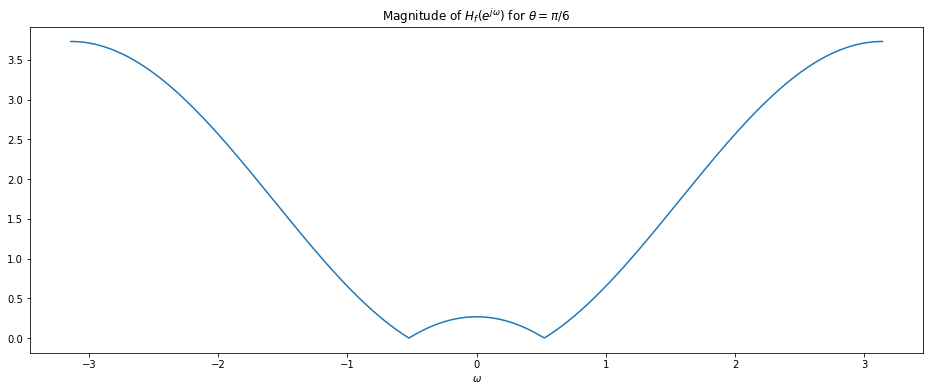

In [3]:
w = np.linspace(-np.pi, np.pi, 2001)
theta = np.pi / 6
H = 1 - 2 * np.cos(theta) * np.exp(-1j * w) + np.exp(-2j * w)
plt.plot(w, np.abs(H))
plt.xlabel(r"$\omega$")
plt.title(r"Magnitude of $H_f(e^{j\omega})$ for $\theta=\pi/6$")
plt.show()

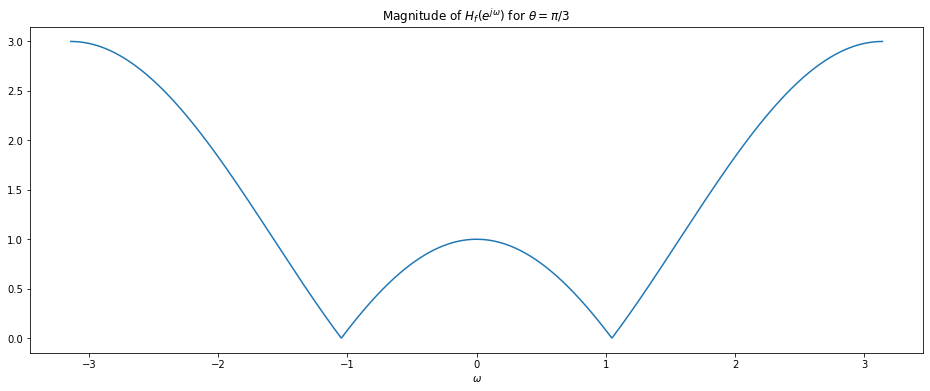

In [4]:
w = np.linspace(-np.pi, np.pi, 2001)
theta = np.pi / 3
H = 1 - 2 * np.cos(theta) * np.exp(-1j * w) + np.exp(-2j * w)
plt.plot(w, np.abs(H))
plt.xlabel(r"$\omega$")
plt.title(r"Magnitude of $H_f(e^{j\omega})$ for $\theta=\pi/3$")
plt.show()

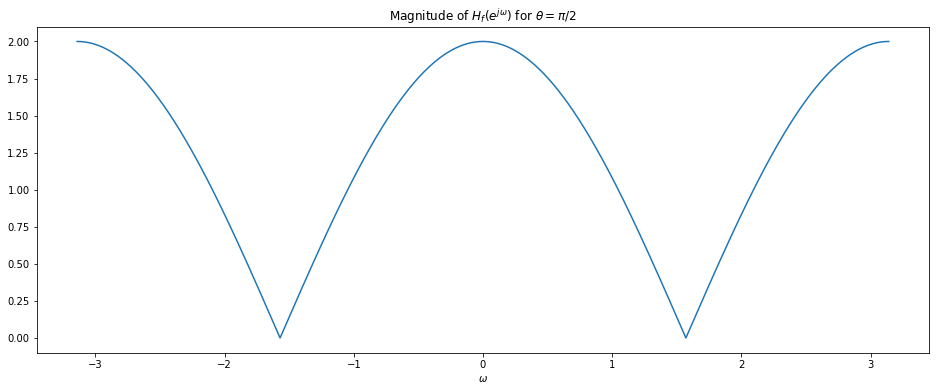

In [5]:
w = np.linspace(-np.pi, np.pi, 2001)
theta = np.pi / 2
H = 1 - 2 * np.cos(theta) * np.exp(-1j * w) + np.exp(-2j * w)
plt.plot(w, np.abs(H))
plt.xlabel(r"$\omega$")
plt.title(r"Magnitude of $H_f(e^{j\omega})$ for $\theta=\pi/2$")
plt.show()

**5. Explain how the value of $\theta$ affects the magnitude of the filter's frequency response.**

Insert your answer here

<h3 style="color:red;"><left>Exercise 3.2</left></h3>

In the next experiment, we will use the filter $H_f(z)$ to remove an undesirable sinusoidal interference from a speech signal. To run the experiment, load ```nspeech1.npy``` into Python using the command ```nspeech1 = np.load("nspeech1.npy")```.

**1. Play ```nspeech1``` using the command ```ipd.Audio(nspeech1, rate=8000)```.**

In [6]:
nspeech1 = np.load("nspeech1.npy")
ipd.Audio(nspeech1, rate=8000)

**2. Plot $101$ samples of the signal for the time indices ```[99:200]```.**

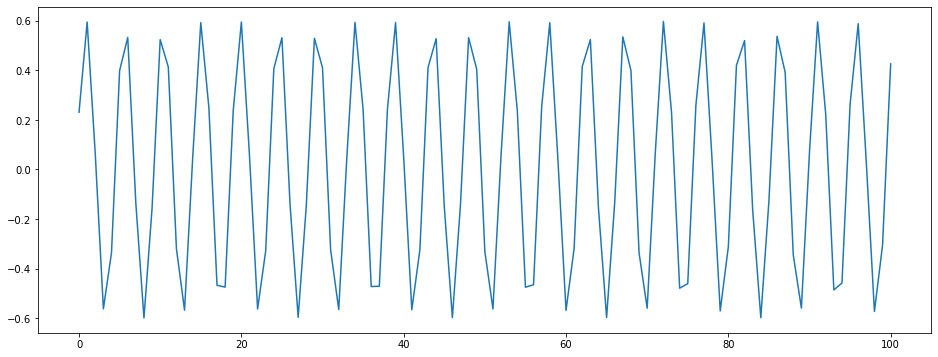

In [7]:
plt.plot(nspeech1[99:200])
plt.show()

---

We will next use the ```DTFT``` function provided in the file ```helper.py``` to compute samples of the DTFT of the audio signal. Run the following code to import the function. Note that the command ```X, w = DTFT(x, 0)``` will generate a DTFT that is the same duration as the input; if this is not sufficient, it may be increased by specifying ```M```.

In [8]:
from helper import DTFT

**3. Compute the the DTFT of $1001$ samples of the audio signal for the time indices ```[99:1100]```. Then plot the magnitude of the DTFT samples versus frequency for $|\omega|<\pi$.**

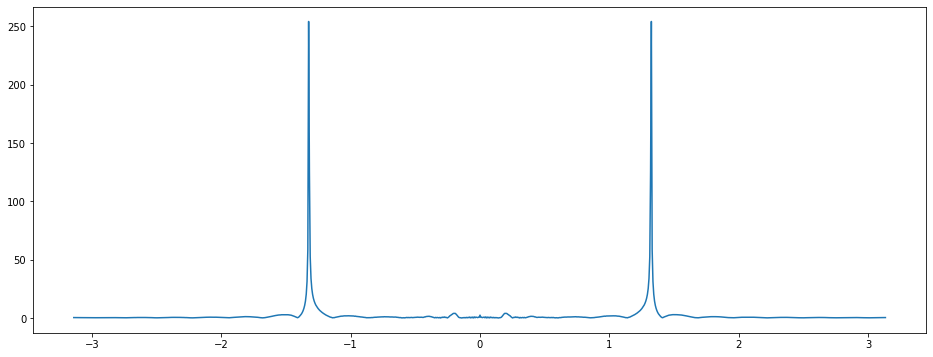

In [9]:
X, w = DTFT(nspeech1[99:1100], 0)
plt.plot(w, np.abs(X))
plt.show()

---

Notice that there are two large peaks corresponding to the sinusoidal interference signal in the plot you drew above.

**4. Use the command [```np.argmax()```](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to determine the exact frequency of the peaks. This will
be the value of $\theta$ that we will use for filtering with $H_f(z)$. Print out the result.**

**Hint:** use the command ```idx_max = np.argmax(np.abs(X))``` to find the index of the maximum element in ```X```. Then $\theta$ can be derived using this index.

In [10]:
idx_max = np.argmax(np.abs(X))
theta_max = w[idx_max]
print(theta_max)

-1.325359400733194


**5. Complete the function ```FIRfilter``` that implements the filter $H_f(z)$ with the measured value of $\theta$ and outputs the filtered signal (Hint: Use ```np.convolve()```).**

In [11]:
def FIRfilter(x, theta):
    """
    Parameters:
    ---
    x: the signal to be filtered
    theta: the value of theta to be used for filtering with H_f(z)
    
    Returns:
    ---
    y: the filtered signal
    """
    h = [1, -2 * np.cos(theta), 1]
    return np.convolve(h, x)

**6. Apply the new function ```FIRfilter``` to the ```nspeech1``` vector to attenuate the sinusoidal interference. Listen to the filtered signal to hear the effects of the filter.**

In [12]:
new_nspeech = FIRfilter(nspeech1, theta_max)
ipd.Audio(new_nspeech, rate=8000)

**7. Comment on how the filtering changed the quality of the audio signal.**

Insert your answer here

**8. Plot $101$ samples of the filtered signal for the time indices ```[99:200]```.**

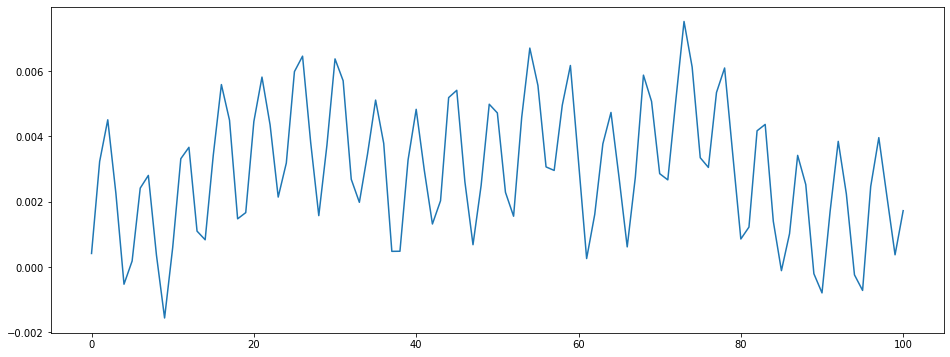

In [13]:
plt.plot(new_nspeech[99:200])
plt.show()

**9. Plot the magnitude of the DTFT of 1001 samples of the filtered signal for the time indices ```[99:1100]```.**

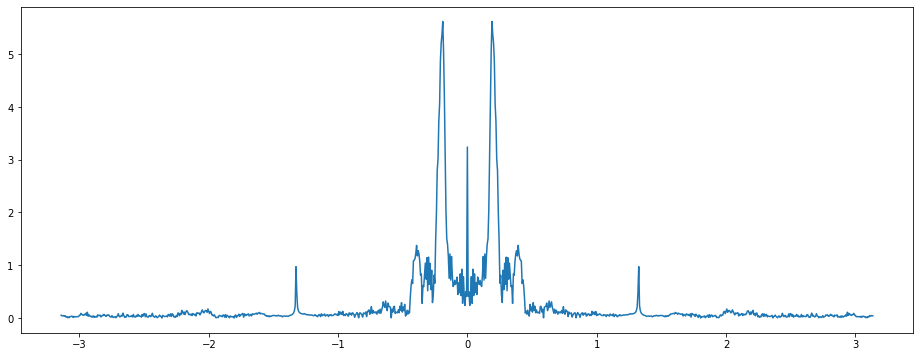

In [14]:
X, w = DTFT(new_nspeech[99:1100], 0)
plt.plot(w, np.abs(X))
plt.show()

**10. Is the filter we used a lowpass, highpass, bandpass, or a bandstop filter? Comment on how the frequency content of the signal changed after filtering.**

Inser your answer here

<h2 style="color:salmon;"><left>4. Design of a Simple IIR Filter</left></h2>

<figure>
    <img src="imgs/figure3.png" style="width:60%">
    <em><center>Figure 3: Location of two poles for a simple IIR filter.</center></em>
</figure>

While zeros attenuate a filtered signal, poles amplify signals that are near their frequency. In this section, we will illustrate how poles can be used to separate a narrow-band signal from adjacent noise. Such filters are commonly used to separate modulated signals from background noise in applications such as radio-frequency demodulation.

Consider the following transfer function for a second order IIR filter with complexconjugate poles:

\begin{align}
    H_i(z)&=\frac{1-r}{(1-re^{j\theta}z^{-1})(1-re^{-j\theta}z^{-1})}\\
    &=\frac{1-r}{1-2r\cos(\theta)z^{-1}+r^2z^{-2}}
\end{align}

Figure 3 shows the locations of the two poles of this filter. The poles have the form

\begin{align}
    p_1=re^{j\theta}\quad p_2=re^{-j\theta}
\end{align}

where $r$ is the distance from the origin, and $\theta$ is the angle of $p_1$ relative to the positive real axis. From the theory of $Z$-transforms, we know that a causal filter is stable if and only if its poles are located within the unit circle. This implies that this filter is stable if and only if $|r| < 1$. However, we will see that by locating the poles close to the unit circle, the filter’s bandwidth may be made extremely narrow around $\theta$.

This two-pole system is an example of an IIR filter because its impulse response has
infinite duration. Any filter with nontrivial poles (not at $z = 0$ or $\pm\infty$) is an IIR filter unless the poles are canceled by zeros.

<h3 style="color:red;"><left>Exercise 4.1</left></h3>

**1. Submit the difference equation for the filter $H_i(z)$.**

$y[n]=(1-r)x[n]+2r\cos\theta y[n-1]-r^2y[n-2]$

**2. Submit the system diagram of the impulse response for the filter $H_i(z)$.**

insert your answer here

**3. Submit the analytical expression of the impulse response for the filter $H_i(z)$.**

**Hint:** the frequency response of the system can be obtained by restricting the $Z$-transform to the unit circle. So the DTFT of $h_i[n]$ is $H_i(e^{j\omega})$. Therefore, to get $h_i[n]$, you can take the inverse Fourier transform of $H_i(e^{j\omega})$.

$h[n]=(1-r)\delta[n]+2r\cos\theta h[n-1]-r^2h[n-2]$

**4. Write Python code to calculate and plot the magnitude of the filter’s frequency response $|H_i(e^{j\omega})|$ on $|\omega| < \pi$ for $\theta = \pi/3$ and the following three values of $r$:**
* $r=0.99$
* $r=0.9$
* $r=0.7$

In [15]:
theta = np.pi / 3
w = np.linspace(-np.pi, np.pi, 2001)

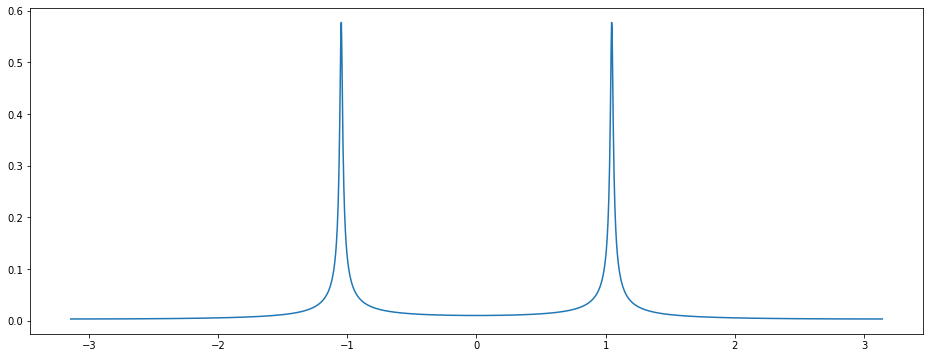

In [16]:
# r = 0.99
r = 0.99
H = (1 - r) / (1 - 2 * r * np.cos(theta) * np.exp(-1j * w) + r ** 2 * np.exp(-2 * 1j * w))
plt.plot(w, np.abs(H))
plt.show()

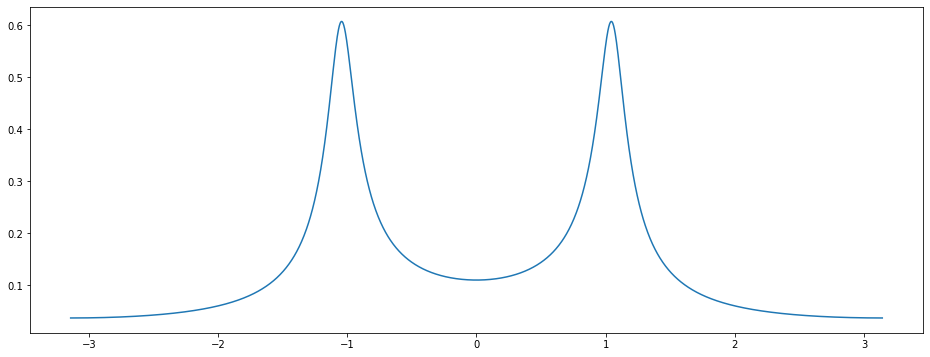

In [17]:
# r = 0.9
r = 0.9
H = (1 - r) / (1 - 2 * r * np.cos(theta) * np.exp(-1j * w) + r ** 2 * np.exp(-2 * 1j * w))
plt.plot(w, np.abs(H))
plt.show()

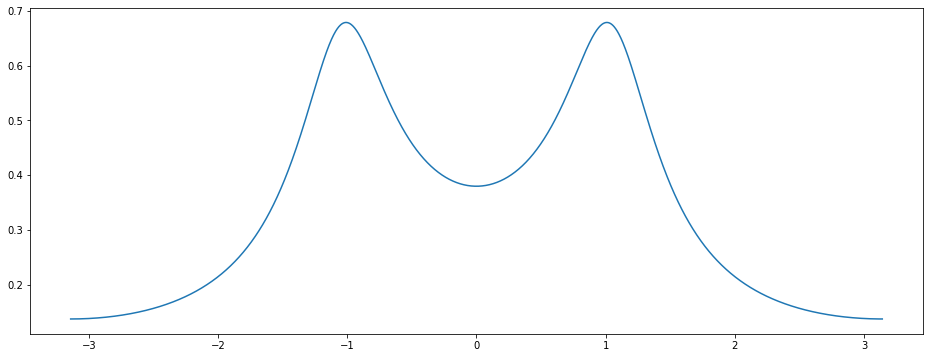

In [18]:
# r = 0.7
r = 0.7
H = (1 - r) / (1 - 2 * r * np.cos(theta) * np.exp(-1j * w) + r ** 2 * np.exp(-2 * 1j * w))
plt.plot(w, np.abs(H))
plt.show()

**5. Explain how the value of $r$ affects this magnitude.**

insert your answer here

<h3 style="color:red;"><left>Exercise 4.2</left></h3>

In the following experiment, we will use the filter $H_i(z)$ to separate a modulated sinusoid from background noise.

**1. Load the file ```pcm.npy``` and play it.**

In [19]:
pcm = np.load("pcm.npy")
ipd.Audio(pcm, rate=8000)

**2. Plot $101$ samples of the signal for the time indices ```[99:200]```.**

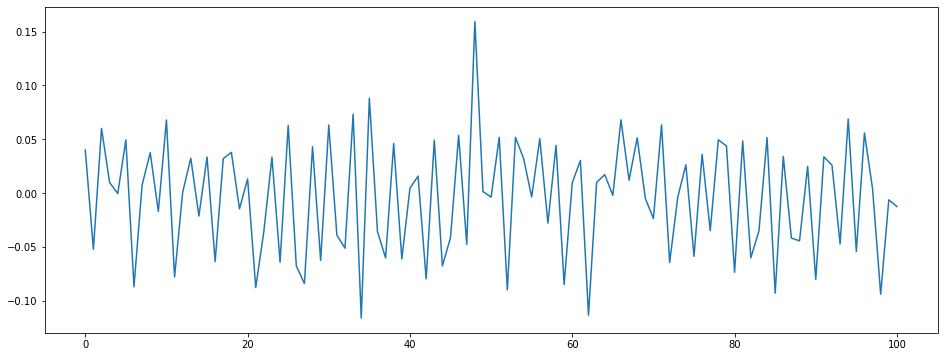

In [20]:
plt.plot(pcm[99:200])
plt.show()

**3. Compute the the DTFT of $1001$ samples of the audio signal for the time indices ```[99:1100]```. Then plot the magnitude of the DTFT samples versus frequency for $|\omega|<\pi$.**

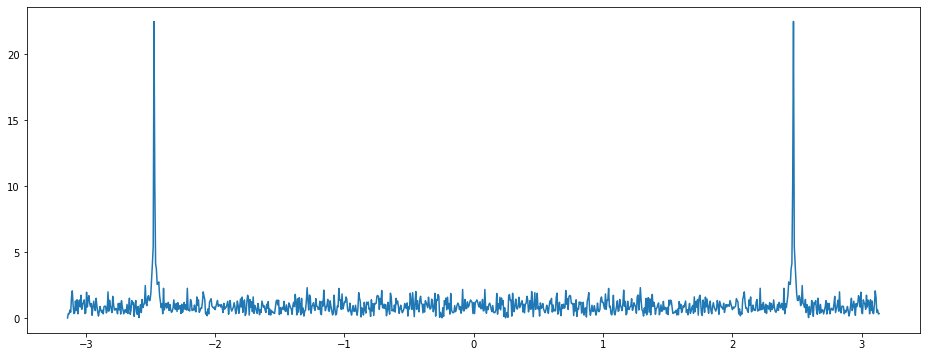

In [21]:
X, w = DTFT(pcm[99:1100], 0)
plt.plot(w, np.abs(X))
plt.show()

---

The two peaks in the spectrum correspond to the center frequency of the modulated signal. The low amplitude wideband content is the background noise. In this exercise, you will use the IIR filter described above to amplify the desired signal, relative to the background noise.

**4. The pcm signal is modulated at $3146\text{ Hz}$ and sampled at $8\text{ kHz}$. Use these values to calculate the value of $\theta$ for the filter $H_i(z)$. Remember from the sampling theorem that a radial frequency of $2\pi$ corresponds to the sampling frequency. Print out the value of $\theta$.**

In [22]:
theta = 3146 / 8000 * 2 * np.pi
print(theta)

2.4708626220483723


**5. Plot the magnitude of the DTFT for $\omega$ in the range $[\theta−0.02, \theta+0.02]$.**

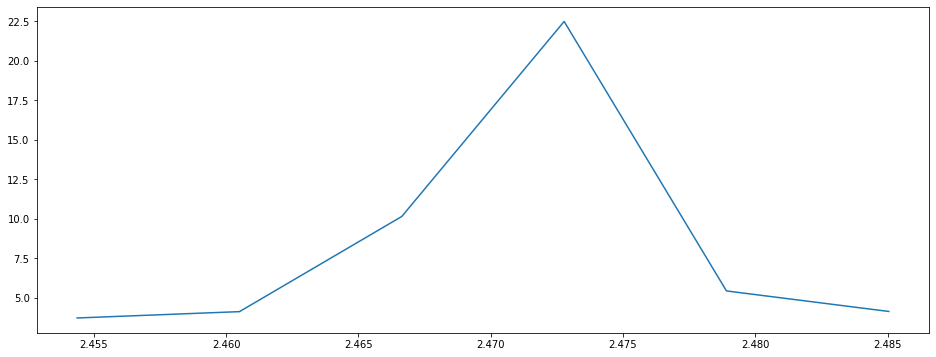

In [23]:
indices = np.argwhere((w >= theta - 0.02) * (w <= theta + 0.02))
plt.plot(w[indices], np.abs(X[indices]))
plt.show()

**6. Complete the function ```IIRfilter``` that implements the filter $H_i(z)$. In this case, you need to use a for loop to implement the recursive difference equation. Use your calculated value of $\theta$ and $r = 0.995$. You can assume that $y[n]$ is equal to $0$ for negative values of $n$.**

In [24]:
def IIRfilter(x, theta):
    r = 0.995
    y = np.zeros(len(x))
    y[0] = (1 - r) * x[0]
    y[1] = (1 - r) * x[1] + 2 * r * np.cos(theta) * y[0]
    for i in range(2, len(y)):
        y[i] = (1 - r) * x[i] + 2 * r * np.cos(theta) * y[i - 1] - r ** 2 * y[i - 2]
    return y

**7. Apply the function ```IIRfilter``` to the signal ```pcm``` to separate the desired signal from the background noise, and listen to the filtered signal to hear the effects.**

In [25]:
pcm_filtered = IIRfilter(pcm, theta)
ipd.Audio(pcm_filtered, rate=8000)

**8. Comment on how the signal sounds before and after filtering.**

insert your answer here

**9. Plot the filtered signal for indices ```[99:200]```.**

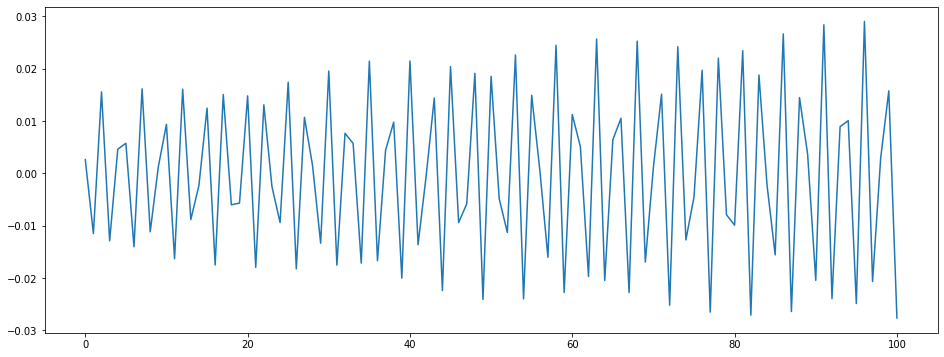

In [26]:
plt.plot(pcm_filtered[99:200])
plt.show()

**10. Compute the DTFT of $1001$ samples of the filtered signal using the time indices ```[99:1100]``` and plot the magnitude of this DTFT.**

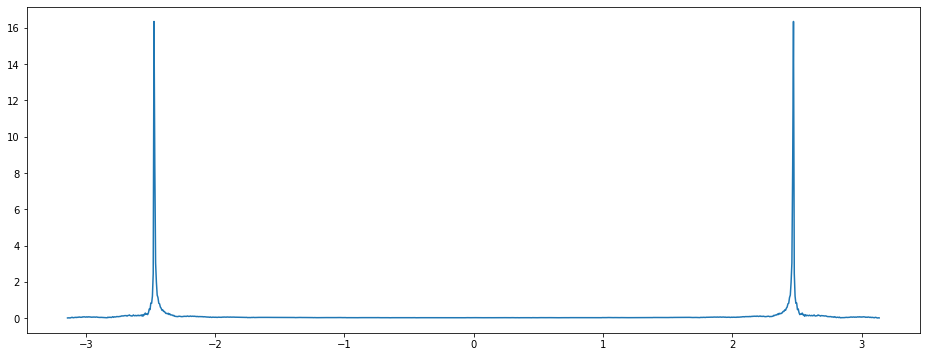

In [27]:
X, w = DTFT(pcm_filtered[99:1100], 0)
plt.plot(w, np.abs(X))
plt.show()

**11. In order to see the DTFT around $\omega = \theta$ more clearly, plot also the portion of this DTFT for the values of $\omega$ in the range $[\theta − 0.02, \theta + 0.02]$. Use your calculated value of $\theta$.**

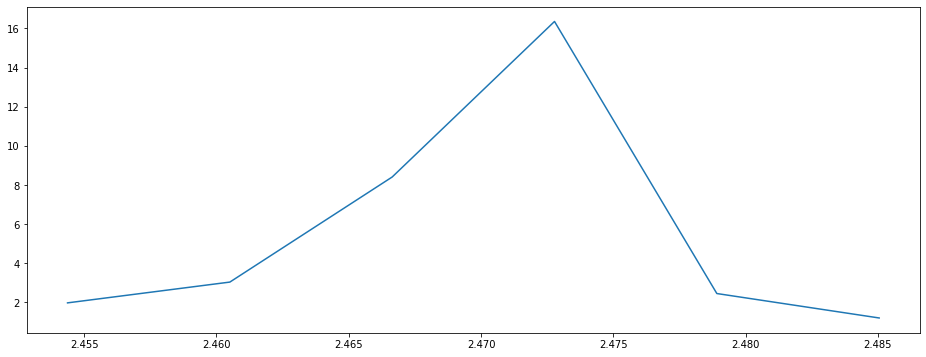

In [28]:
indices = (w >= theta - 0.02) & (w <= theta + 0.02)
plt.plot(w[indices], np.abs(X[indices]))
plt.show()

**12. Comment on how the signal looks before and after filtering.**

insert your answer here

**13. How would you expect changes in $r$ to change the filtered output? Would a value of $r = 0.9999999$ be effective for this application? Why might such a value for $r$ be ill-advised? (Consider the spectrum of the desired signal around $\omega = \theta$.)**

insert your answer here

<h2 style="color:salmon;"><left>5. Lowpass Filter Design Parameters</left></h2>

<figure>
    <img src="imgs/figure4.png" style="width:60%">
    <em><center>Figure 4: Tolerance specifications for the frequency response of a filter.</center></em>
</figure>

Oftentimes it is necessary to design a good approximation to an ideal lowpass, highpass or bandpass filter. Figure 4 illustrates the typical characteristics of a real low-pass filter. The frequencies $|\omega| < \omega_p$ are known as the passband, and the frequencies $\omega_s < |\omega| \leq \pi$ are the stopband. For any real filter, $\omega_p < \omega_s$. The range of frequencies $\omega_p \leq \omega \leq \omega_s$ is known as the transition band. The magnitude of the filter response, $H(e^{j\omega})$, is constrained in the passband and stopband by the following two equations

\begin{align}
    |H(e^{j\omega})-1|&\leq\delta_p\quad\text{for }|\omega|<\omega_p\\
    |H(e^{j\omega})|&\leq\delta_s\quad\text{for }\omega_s<|\omega|\leq\pi
\end{align}

where $\delta_p$ and $\delta_s$ are known as the passband and stopband ripple respectively. Most lowpass filter design techniques depend on the specification of these four parameters: $\omega_p$, $\omega_s$, $\delta_p$, and $\delta_s$.

<figure>
    <img src="imgs/figure5.png" style="width:60%">
    <em><center>Figure 5: DTFT of a section of noisy speech.</center></em>
</figure>

To illustrate the selection of these parameters consider the problem of filtering out background noise from a speech signal. Figure 5 shows the magnitude of the DTFT over a
window of such a signal, called ```nspeech2```. Notice that there are two main components in ```nspeech2```: one at the low frequencies and one at the high. The high frequency signal is noise, and it is band limited to $|\omega| > 2.2$. The low frequency signal is speech and it is band limited to $|\omega| < 1.8$.

In the following sections, we will compute low-pass filters for separating the speech and
noise using a number of different methods.

<h3 style="color:salmon;"><left>5.1 Filter Design Using Truncation</left></h3>

Ideally, a low-pass filter with cutoff frequency $\omega_c$ should have a frequency response of

\begin{align}
    H_{\text{ideal}}(e^{j\omega})=\begin{cases}1&|\omega|\leq\omega_c\\0&\omega_c<|\omega|\leq\pi\end{cases}
\end{align}

and a corresponding impulse response of

\begin{align}
    h_{\text{ideal}}[n]=\frac{\omega_c}{\pi}\text{sinc}\left(\frac{\omega_c n}{\pi}\right)\quad\text{for }-\infty<n<\infty\tag{4}
\end{align}

However, no real filter can have this frequency response because $h_{\text{ideal}}[n]$ is infinite in duration.

One method for creating a realizable approximation to an ideal filter is to truncate this
impulse response outside of $n \in [−M, M]$.

\begin{align}
    h_{\text{trunc}}[n]=\begin{cases}\frac{\omega_c}{\pi}\text{sinc}\left(\frac{\omega_c}{\pi}n\right)&n=-M,\dots,0,1,\dots,M\\0&\text{otherwise}\end{cases}
\end{align}

Figure 6 shows the magnitude response of the lowpass filter with cutoff frequency $\omega_c = 2.0$, with the impulse response truncated to $n \in [−10, 10]$. Notice the oscillatory behavior of the magnitude response near the cutoff frequency and the large amount of ripple in the stopband.

<figure>
    <img src="imgs/figure6.png" style="width:60%">
    <em><center>Figure 6: Frequency response of low-pass filter designed using the truncation method.</center></em>
</figure>

Due to the modulation property of the DTFT, the frequency response of the truncated filter is the result of convolving the magnitude response of the ideal filter (a rect) with the DTFT of the truncating window. The DTFT of the truncating window, shown in Figure 7, is
similar to a sinc function since it is the DTFT of a sampled rectangular window. Notice that this DTFT has very large sidelobes, which lead to large stopband ripple in the final filter.

<figure>
    <img src="imgs/figure7.png" style="width:60%">
    <em><center>Figure 7: DTFT of a rectangular window of size 21.</center></em>
</figure>

A truncated impulse response is of finite duration, yet the filter is still noncausal. In
order to make the FIR filter causal, it must be shifted to the right by $M$ units. For a filter of size $N = 2M + 1$ this shifted and truncated filter is given by

\begin{align}
    h[n]=\begin{cases}\frac{\omega_c}{\pi}\text{sinc}\left(\frac{\omega_c}{\pi}\left(n-\frac{N-1}{2}\right)\right)&n=0,1,\dots,N-1\\0&\text{otherwise}\end{cases}\tag{5}
\end{align}

This time shift of ```(N − 1) / 2``` units to the right corresponds to multiplying the frequency
response by $e^{−jω(N−1)/2}$. It does not affect the magnitude response of the filter, but adds a factor of $−jω(N − 1)/2$ to the phase response. Such a filter is called linear phase because the phase is a linear function of $\omega$.

It is interesting to see that the filter formula of (5) is valid for $N$ both even and odd.
While both of these filters are linear phase, they have different characteristics in the time domain. When $N$ is odd, then the value at ```n = (N − 1)/2``` is sampled at the peak of the sinc function, but when $N$ is even, then the two values at ```n = N/2``` and ```n = (N/2) − 1``` straddle the peak.

<h3 style="color:red;"><left>Exercise 5.1</left></h3>

**1. To examine the effect of filter size on the frequency characteristics of the filter, complete the function ```LPFtrunc(N)``` that computes the truncated and shifted impulse response of size ```N``` for a low pass filter with a cutoff frequency of $\omega_c = 2.0$.**

In [29]:
def LPFtrunc(N):
    n = np.arange(N)
    w = 2.0
    h = w / np.pi * np.sinc(w / np.pi * (n - (N - 1) / 2))
    return h

**2. For each of the following filter sizes, compute the filter’s DTFT.**
* $N=21$
* $N=101$

**Hints:** To get an accurate representation of the DTFT make sure that you compute at
least $512$ sample points using the command ```X, w = DTFT(filter_response, 512)```.

In [30]:
filter_response1 = LPFtrunc(21)
filter_response2 = LPFtrunc(101)
X1, w1 = DTFT(filter_response1, 512)
X2, w2 = DTFT(filter_response2, 512)

**3. Plot the magnitude of both filters' DTFTs. On each of the plots, mark the passband, the transition band and the stopband.**

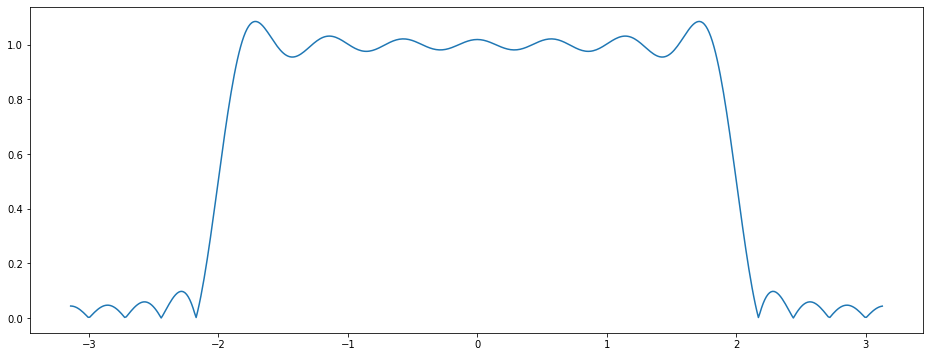

In [31]:
# N = 21
plt.plot(w1, np.abs(X1))
plt.show()

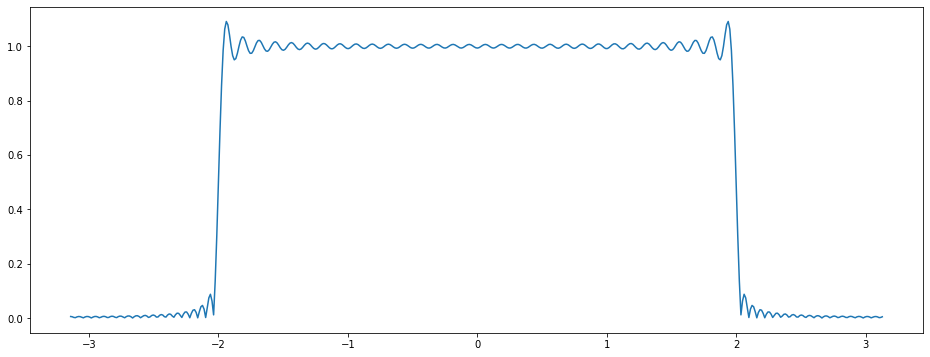

In [32]:
# N = 101
plt.plot(w2, np.abs(X2))
plt.show()

**4. Plot the magnitude of both filters' DTFTs in decibels.**

**Hint:** the magnitude of the response in decibels is given by $|H_{\text{dB}}(e^{j\omega})| = 20 \log10 |H(e^{j\omega})|$. Note that the ```np.log``` command in Python computes the natural logarithm. Therefore, use the ```np.log10``` command to compute
decibels. 

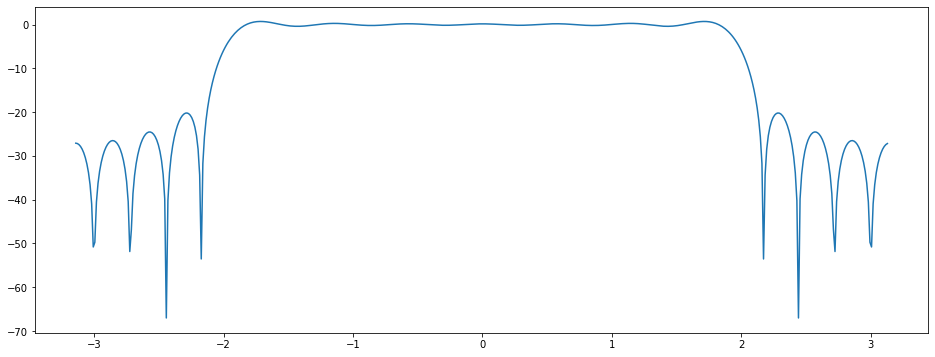

In [33]:
# N = 21
plt.plot(w1, 20 * np.log10(np.abs(X1)))
plt.show()

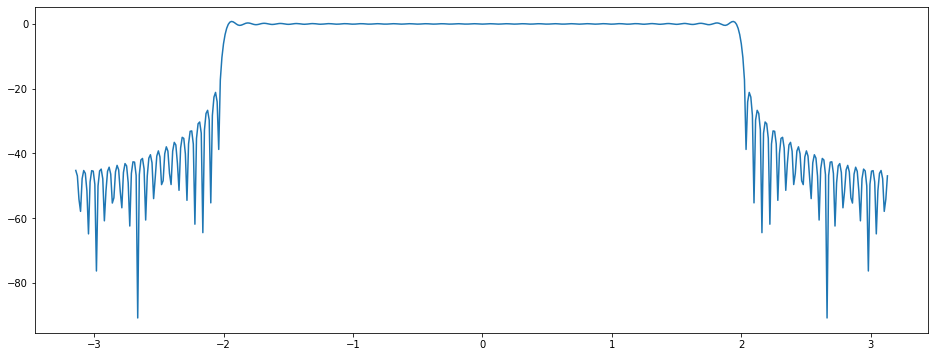

In [34]:
# N = 101
plt.plot(w2, 20 * np.log10(np.abs(X2)))
plt.show()

**5. Explain how the filter size effects the stopband ripple. Why does it have this effect?**

insert your answer here

**6. Load the file ```nspeech2.npy``` and play it. Also, note the quality of the speech and background noise.**

In [35]:
nspeech2 = np.load("nspeech2.npy")
ipd.Audio(nspeech2, rate=8000)

**7. Apply the two filters with the above sizes to this signal. Since these are FIR filters, you can simply convolve them with the audio signal. Listen carefully to the unfiltered and filtered signals, and note the result. Can you hear a difference between the two filtered signals? In order to hear the filtered signals better, you may want to multiply each of them by 2 or 3 before using sound.**

In [36]:
speech_f1 = np.convolve(nspeech2, filter_response1)
ipd.Audio(speech_f1, rate=8000)

In [37]:
speech_f2 = np.convolve(nspeech2, filter_response2)
ipd.Audio(speech_f2, rate=8000)

insert your answer here

**8. Comment on the quality of the filtered signals. Does the filter size have a noticeable
effect on the audio quality?**

insert your answer here